In [1]:
import numpy as np
import matplotlib.pyplot as plt
import lightkurve as lk
from astropy.units import cds
from astropy import units as u
import matplotlib
matplotlib.rc('xtick', labelsize=20)
matplotlib.rc('ytick', labelsize=20)
matplotlib.rc('axes',labelsize=20)


#The stellar parameters are for 16 Cyg A
nus = 0.411 #uHz
i = np.deg2rad(56.) #rad
d02 = 6.8 #uHz
dnu = 102. #uHz

In [2]:
import pystan
model = '''
functions{
    real lorentzian(real loc, int l, int m, real f, real i, real H, real w, real nus){
        return H ./ (1 + (4/w^2) * (f - loc + m*nus)^2);
    }

    real[] multiplet(int N, real[] locs, real[] f, real i, real H, real w, real nus){
        real mod[N];
        mod = rep_array(1., N);
        
        for (l in 0:3){
            for (m in -l:l){
                for (n in 1:N){
                    mod[n] += lorentzian(locs[l+1], l, m, f[n], i, H, w, nus);
                }
            }
        }
        return mod;
    }

    real testing(real[] locs){
        real mod;
        mod = 1.;
        mod += locs[1];
        return mod;
    }
}
data{
    int N;
    real f[N];
    real i;
    real H;
    real w;
    real nus;
    real locs[4];
}
generated quantities{
    real mod;
    real lor[N];
    real mult[N];
    real test;
    real beta[N];
    real beta2[N];
    mod = 1.;
    
    for (l in 0:3){
        for (m in -l:l){
            mod += locs[l+1];
        }
    }
    test = testing(locs);
    
    for (n in 1:N){
        lor[n] = lorentzian(0., 1, 0, f[n], i, H, w, nus);
    }    
    
    mult = multiplet(N, locs, f, i, H, w, nus);
    
    for (n in 1:N){
        beta[n] = 1.0 / mult[n];
    }

}

'''
sm = pystan.StanModel(model_code=model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8f83f21c15f4461b3fdcf582efcd2adb NOW.


In [5]:
data = {'N':100,
        'locs':[1,4,6,8],
       'f':np.linspace(0., 100., 100),
       'i':np.deg2rad(56.),
       'H':14,
       'w':1.,
       'nus':0.411}

fit = sm.sampling(data=data, iter=1, chains=1,algorithm='Fixed_param')
print(fit['mod'])

100.0


- the for (m in -l:l) works great

- I can select from locs fine, by the looks of it

- We can generate a lorentzian

- When passing a real array to a function, pass as real[]

- You cant' raise vectors to a power, so need to use real[]

- Looks like I may have multiplet working

- Can't invert a real array, need to do it value by value as usual

INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.


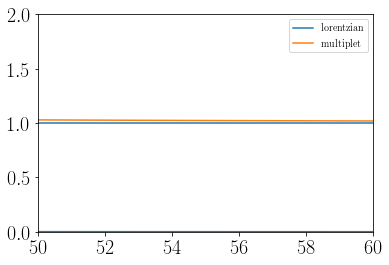

In [9]:
plt.plot(data['f'], fit['lor'].T, label='lorentzian')
plt.plot(data['f'], fit['mult'].T, label='multiplet')
plt.scatter(np.array(data['locs']), np.ones_like(data['locs'])*40.)
plt.legend()
plt.xlim(50,60) 
plt.ylim(0.,2.)
plt.axhline(1.)
plt.show()